### Mxnet GPU vs CPU Runtime Shootout on a GTX780 Gaming Machine
2017-12

<table>
    <tr>
        <td>
            <img src="gaming_pc_deep_learning.jpeg" width="370" />
            GTX780 vs i7-2600 3.4G
        </td>
        <td>
            <img src="gaming_pc_deep_learning_2.jpeg" width="370" />
            sitting nicely in my garage
        </td>
    </tr>
</table>

If you are considering converting your old gaming PC into a deep learning box, then this is a rough estimate of how much speed gain you might get. 

Depending on your task, in this experiment I could get about 3x speedup gain on increasing epoch size with fixed matrix size, and an order of magnitude gain on increasing matrix size with fixed epoch size. So, if your project involve large matrix factorization tasks, using a GPU would save you a lot of time.

Overall, for this particular hardware spec, it's safe to say that I should be getting <b>4x+</b> speedup with a GPU than only using the CPU.

#### Experiment environment

* CPU: Intel Core i7-2600 Quad-Core Processor 3.4 GHz
* GPU: 1 x GeForce GTX780 3GB GDDR5
* Ram: 16G DDR3
* Harddrive: 128G SSD 
* OS: Ubuntu 16.04
* Deep learning framework: mxnet 1.0

Please note this is not a dockerized environment.

In [1]:
%pylab inline

import pandas as pd
import numpy as np
import timeit
import mxnet as mx
import seaborn; seaborn.set_style('whitegrid')
import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
print(mx.__version__)

Populating the interactive namespace from numpy and matplotlib
1.0.0


In [2]:
import os
import urllib.request
import zipfile

if not os.path.exists('ml-20m.zip'):
    urllib.request.urlretrieve('http://files.grouplens.org/datasets/movielens/ml-20m.zip', 'ml-20m.zip')

with zipfile.ZipFile("ml-20m.zip", "r") as f:
    f.extractall("./")

data = pd.read_csv('./ml-20m/ratings.csv', sep=',', usecols=(0, 1, 2))
data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [3]:
print("user id min/max: ", data['userId'].min(), data['userId'].max())
print("# unique users: ", numpy.unique(data['userId']).shape[0])
print("")
print("movie id min/max: ", data['movieId'].min(), data['movieId'].max())
print("# unique movies: ", numpy.unique(data['movieId']).shape[0])

user id min/max:  1 138493
# unique users:  138493

movie id min/max:  1 131262
# unique movies:  26744


In [4]:
n_users, n_movies = 138493, 131262
batch_size = 1024

In [5]:
n = 100000

data = data.sample(frac=1).reset_index(drop=True) # Shuffle the data in place row-wise

train_users = data['userId'].values[:n] - 1
train_movies = data['movieId'].values[:n] - 1
train_ratings = data['rating'].values[:n]

valid_users = data['userId'].values[n:] - 1
valid_movies = data['movieId'].values[n:] - 1
valid_ratings = data['rating'].values[n:]

X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                                label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                               label=valid_ratings, batch_size=batch_size)

In [6]:
def run_exp(context=mx.cpu(0), num_epoch=3, dim=25):
    X_train.reset()
    X_eval.reset()

    user = mx.symbol.Variable("user")
    user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=dim)
    movie = mx.symbol.Variable("movie")
    movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=dim)

    y_true = mx.symbol.Variable("softmax_label")
    y_pred = mx.symbol.sum_axis(data=(user * movie), axis=1)
    y_pred = mx.symbol.flatten(y_pred)
    y_pred = mx.symbol.LinearRegressionOutput(data=y_pred, label=y_true)

    start_time = timeit.default_timer()
    model = mx.module.Module(context=context, data_names=('user', 'movie'), symbol=y_pred)
    model.fit(X_train, 
              num_epoch=num_epoch, 
              optimizer='adam', 
              optimizer_params=(('learning_rate', 0.001),),
              eval_metric='rmse', eval_data=X_eval)

    elapsed = timeit.default_timer() - start_time
    #print('{} {} {}'.format(num_epoch, dim, elapsed))
    return elapsed

### Runtime comparison - Fixed dimension size with increasing epoch size

In [7]:
x = list(range(1, 10, 1))
dim = 25
gpu_vals_1 = []
for ii in x:
    gpu_vals_1.append(run_exp(context=mx.gpu(0), num_epoch=ii, dim=dim))
    
cpu_vals_1 = []
for ii in x:
    cpu_vals_1.append(run_exp(context=mx.cpu(0), num_epoch=ii, dim=dim))    

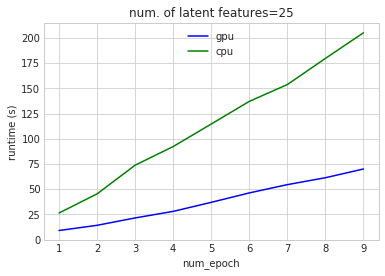

In [8]:
fig, ax = plt.subplots()
ax.plot(x, gpu_vals_1, 'k-', label='gpu', c='blue')
ax.plot(x, cpu_vals_1, 'k-', label='cpu', c='green')
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('runtime (s)')
plt.xlabel('num_epoch')
plt.title('num. of latent features=25')
plt.show()

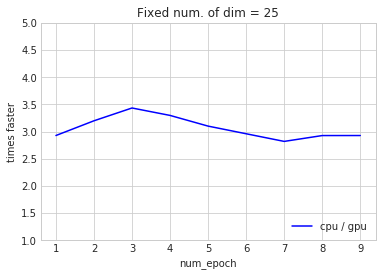

In [17]:
fig, ax = plt.subplots()
ax.plot(x, np.array(cpu_vals_1)/np.array(gpu_vals_1), 'k-', label='cpu / gpu', c='blue')
legend = ax.legend(loc='lower right', shadow=True)
plt.ylabel('times faster')
plt.xlabel('num_epoch')
plt.title('Fixed num. of dim = 25')
plt.ylim([1,5])
plt.show()

### Runtime comparison - Fixed number of epoches with increasing dimension size

In [10]:
dims = list(range(10, 100, 10))
num_epoch = 10
gpu_vals_2 = []
for dd in dims:
    gpu_vals_2.append(run_exp(context=mx.gpu(0), num_epoch=num_epoch, dim=dd))
    
cpu_vals_2 = []
for dd in dims:
    cpu_vals_2.append(run_exp(context=mx.cpu(0), num_epoch=num_epoch, dim=dd))
    

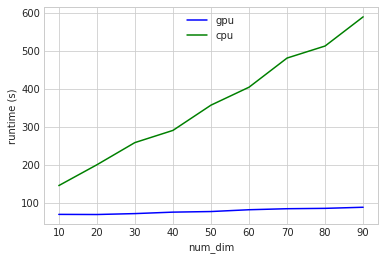

In [11]:
fig, ax = plt.subplots()
ax.plot(dims, gpu_vals_2, 'k-', label='gpu', c='blue')
ax.plot(dims, cpu_vals_2, 'k-', label='cpu', c='green')
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('runtime (s)')
plt.xlabel('num_dim')
plt.show()

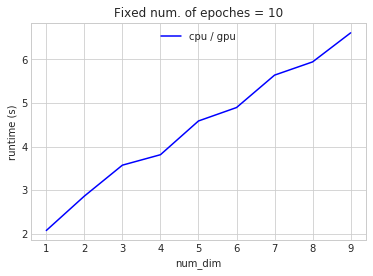

In [13]:
fig, ax = plt.subplots()
ax.plot(x, np.array(cpu_vals_2)/np.array(gpu_vals_2), 'k-', label='cpu / gpu', c='blue')
legend = ax.legend(loc='upper center', shadow=True)
plt.ylabel('runtime (s)')
plt.xlabel('num_dim')
plt.title('Fixed num. of epoches = {}'.format(num_epoch))
plt.show()